In [1]:
import pandas as pd
dt = pd.read_csv('subset-LA-even-fulltext.csv')
# dt = dt[dt.Duration<=720]

In [2]:
import pandas as pd

def merge_dataframe_columns(df, exclude_columns=[]):
    # Create an empty list to store the result strings
    result_strings = []

    # Iterate through each row in the DataFrame
    for _, row in df.iterrows():
        # Create a dictionary to store the key-value pairs
        key_value_pairs = {}
        
        # Iterate through each column in the DataFrame
        for column, value in row.items():
            # Check if the column should be excluded
            if column not in exclude_columns:
                # Convert the value to a string and add it to the dictionary
                key_value_pairs[column] = str(value)
        
        # Convert the dictionary to a comma-separated string of "key:value" pairs
        merged_string = ', '.join([f'{key} : {value}' for key, value in key_value_pairs.items()])
        
        # Append the merged string to the result list
        result_strings.append(merged_string)

    return result_strings

# Example usage:
# Create a sample DataFrame
# data = {'Name': ['Alice', 'Bob', 'Charlie'],
#         'Age': [25, 30, 35],
#         'City': ['New York', 'San Francisco', 'Los Angeles']}

# df = pd.DataFrame(data)

# Merge all columns into a comma-separated string, excluding the 'City' column
dt['fulltext'] = merge_dataframe_columns(dt, exclude_columns=['Duration','fulltext','Description'])



In [3]:
dt.fulltext[0]

'ID : A-7463401, Source : Source1, Severity : 3, Start_Lat : 32.68116, Start_Lng : -97.02426, End_Lat : 32.67618, End_Lng : -97.03483, Distance(mi) : 0.7040000000000001, Street : President George Bush Tpke S, City : Grand Prairie, County : Dallas, State : TX, Zipcode : 75052, Timezone : US/Central, Airport_Code : KGPM, Temperature(F) : 48.2, Wind_Chill(F) : nan, Humidity(%) : 75.0, Pressure(in) : 30.26, Visibility(mi) : 10.0, Wind_Direction : South, Wind_Speed(mph) : 5.8, Precipitation(in) : nan, Weather_Condition : Mostly Cloudy, Amenity : False, Bump : False, Crossing : False, Give_Way : False, Junction : True, No_Exit : False, Railway : False, Roundabout : False, Station : False, Stop : False, Traffic_Calming : False, Traffic_Signal : False, Sunrise_Sunset : Night, Civil_Twilight : Night, Nautical_Twilight : Night, Astronomical_Twilight : Night, Start_Time_hour : 22, Start_Time_month : 1, Weather_Timestamp_hour : 22, Weather_Timestamp_month : 1'

In [4]:
# for s in dir(transformers):
#     print(s)

In [ ]:
import transformers
import torch
import numpy as np
from torch import nn
from transformers import AutoTokenizer, AlbertModel
from transformers import AutoTokenizer, DistilBertModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check if GPU is available
from transformers import AutoTokenizer


def load_model(model_name):
    if model_name.lower() == 'roberta-large':
        model_type = "roberta-large"
        tokenizer = transformers.RobertaTokenizer.from_pretrained(model_type)
        model = transformers.RobertaModel.from_pretrained(model_type)
        
#     elif model_name.lower() == 'mobilebert':
        
#         tokenizer = transformers.AutoTokenizer.from_pretrained("google/mobilebert-uncased")
#         model = transformers.AutoModel.from_pretrained("google/mobilebert-uncased")

    elif model_name.lower() == 'albert':
        model_type = 'albert-base-v2'
        tokenizer = transformers.AutoTokenizer.from_pretrained(model_type)
        model = transformers.AutoModel.from_pretrained(model_type)

    elif model_name.lower() == 'albert-large':
        model_type = 'albert-xxlarge-v2'
        tokenizer = transformers.AutoTokenizer.from_pretrained(model_type)
        model = transformers.AutoModel.from_pretrained(model_type)
        
    elif model_name.lower() == 'bert':
        model_type = 'bert-base-uncased'
        tokenizer = transformers.BertTokenizer.from_pretrained(model_type)
        model = transformers.BertModel.from_pretrained(model_type)
    elif model_name.lower() == 'bert-large':
        model_type = 'bert-large-uncased'
        tokenizer = transformers.BertTokenizer.from_pretrained(model_type)
        model = transformers.BertModel.from_pretrained(model_type)
    elif model_name.lower() == 'gpt2':
        model_type = 'gpt2'
        tokenizer = transformers.GPT2Tokenizer.from_pretrained(model_type)
        model = transformers.GPT2Model.from_pretrained(model_type)
        tokenizer.pad_token = tokenizer.eos_token
        
    elif model_name.lower() == 'gpt2-large':
        model_type = 'gpt2-large'
        tokenizer = transformers.GPT2Tokenizer.from_pretrained(model_type)
        model = transformers.GPT2Model.from_pretrained(model_type)
        tokenizer.pad_token = tokenizer.eos_token
        
    elif model_name.lower() == 'roberta':
        model_type = 'roberta-base'
        tokenizer = transformers.RobertaTokenizer.from_pretrained(model_type)
        model = transformers.RobertaModel.from_pretrained(model_type)
    elif model_name.lower() == 'xlnet':
        model_type = 'xlnet-base-cased'
        tokenizer = transformers.XLNetTokenizer.from_pretrained(model_type)
        model = transformers.XLNetModel.from_pretrained(model_type)
    elif model_name.lower() == 'xlnet-large':
        model_type = 'xlnet-large-cased'
        tokenizer = transformers.XLNetTokenizer.from_pretrained(model_type)
        model = transformers.XLNetModel.from_pretrained(model_type)
        model.to("cuda")
    elif model_name.lower() == 'mt5':
        model_type = 'google/mt5-base'
        tokenizer = transformers.AutoTokenizer.from_pretrained(model_type,fast=False)
        model = transformers.AutoModel.from_pretrained(model_type)
    elif model_name.lower() == 'mt5-large':
        model_type = 'google/mt5-large'
        tokenizer = transformers.AutoTokenizer.from_pretrained(model_type,fast=False)
        model = transformers.AutoModel.from_pretrained(model_type)
    else:
        raise ValueError("Model name not supported. Choose from ['bert', 'gpt2', 'roberta', 'xlnet', 'bloom']")
    
#     model = nn.DataParallel(model, device_ids=[0, 1])
    model = model.to(device)
    return tokenizer, model
import time

def extract_features(texts, model_name='bert', batch_size=40):
    tokenizer, model = load_model(model_name)
    all_features = []
    time_stats = []  # Array to collect run time statistics

    total_batches = (len(texts) + batch_size - 1) // batch_size

    for i in range(0, len(texts), batch_size):
        start_time = time.time()
        batch_num = i // batch_size + 1
        print(f"Processing batch {batch_num}/{total_batches}")

        batch_texts = texts[i:i+batch_size]
        tokenized_texts = [tokenizer.encode(text, add_special_tokens=True, padding='max_length', max_length=500, truncation=True) for text in batch_texts]

        max_length = max(len(seq) for seq in tokenized_texts)
        padded_sequences = [seq + [0] * (max_length - len(seq)) for seq in tokenized_texts]

        input_ids = torch.tensor(padded_sequences)
        attention_masks = torch.where(input_ids != 0, torch.tensor(1), torch.tensor(0))
        
        IDS = input_ids.to(model.device)
        
        with torch.no_grad():
            if model_name.lower() == 'mt5':
                print('this is mt5')
                input_embeds = model.get_input_embeddings()(IDS)
#                 input_embeds = model.get_input_embeddings()(IDS)
#                 features = model(input_ids=IDS, decoder_inputs_embeds=input_embeds)[0]
                features= model(input_ids=IDS, decoder_input_ids = IDS)[0]
                features = features.mean(dim=1)
                print('obtained features')
            elif model_name.lower() == 'mt5-large':
                features = model(input_ids=IDS, decoder_input_ids=IDS)[0]
                features = features.mean(dim=1)
            else:
                
                features = model(input_ids=IDS, attention_mask=attention_masks.to(model.device))[0][:, 0, :]

        features_np = features.cpu().numpy()
        all_features.append(features_np)

        # Calculate time taken and append to statistics
        elapsed_time = time.time() - start_time
        time_stats.append(elapsed_time)
        print(f"Batch {batch_num}/{total_batches} processed in {elapsed_time:.2f} seconds (time per batch)")

    print("Run time statistics:")
    print(f"Average time per batch: {np.mean(time_stats):.2f} seconds")
    print(f"Total time: {np.sum(time_stats):.2f} seconds")
    
    del model
    torch.cuda.empty_cache()
    
    return np.vstack(all_features), time_stats  # Return time statistics along with features



In [6]:

# torch.cuda.empty_cache()

In [ ]:
import numpy as np

def extract_and_save_features(texts, model_name):
    # Extract features
    features,times = extract_features(texts, model_name)
    
    print(times)
    
    # Save features to disk
#     np.save(f'{model_name}_features.npy', features)
    np.savez(f'{model_name}_features.npz', features=features)

    print(f"Features extracted and saved for model: {model_name}")
    del features

# Define the list of model names
#  ,'mt5','mt5-large'
# model_names = []
# model_names = []
model_names = ['bert', 'bert-large', 'roberta', 'mt5', 'mt5-large', 'xlnet','xlnet-large','roberta-large','albert','albert-large']
# model_names = ['albert-large']

# For each model, extract and save features
for model_name in model_names:
    print(model_name)
    extract_and_save_features(dt.fulltext, model_name)

In [4]:
print(dt.Duration.astype(float).value_counts()[:20])

30.0     8233
45.0     4303
360.0    4135
29.0     3769
60.0     2728
         ... 
84.0      102
99.0      101
300.0     101
95.0      100
20.0       99
Name: Duration, Length: 64, dtype: int64


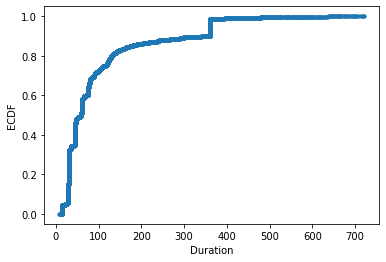

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    return x, y

# Example usage:
durations = dt['Duration'].astype(float)
x, y = ecdf(durations)
plt.plot(x, y, marker='.', linestyle='none')
plt.xlabel('Duration')
plt.ylabel('ECDF')
plt.show()


In [6]:
import pandas as pd

def print_percentile_table(data):
    percentiles = range(1, 101)
    values = [np.percentile(data, p) for p in percentiles]

    percentile_table = pd.DataFrame({
        'Percentile': percentiles,
        'Value': values
    })

    print(percentile_table)

# Example usage:
durations = dt['Duration'].astype(float)
print_percentile_table(durations)


    Percentile   Value
0            1   15.00
1            2   15.00
2            3   15.00
3            4   15.00
4            5   25.00
..         ...     ...
95          96  360.00
96          97  360.00
97          98  360.00
98          99  416.87
99         100  720.00

[100 rows x 2 columns]


In [12]:
# !pip install sentencepiece

In [8]:
import numpy as np

def extract_and_save_features(texts, model_name):
    # Extract features
    features,times = extract_features(texts, model_name)
    
    print(times)
    
    # Save features to disk
    np.save(f'{model_name}_features.npy', features)

    print(f"Features extracted and saved for model: {model_name}")
    del features

# Define the list of model names
# model_names = ['bert', 'gpt2', 'roberta', 'mt5', 'xlnet','xlnet-large']
model_names = ['bert-large']
# For each model, extract and save features
for model_name in model_names:
    print(model_name)
    extract_and_save_features(dt.FullText, model_name)

bert-large


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Processing batch 1/762
Batch 1/762 processed in 14.49 seconds (time per batch)
Processing batch 2/762
Batch 2/762 processed in 12.24 seconds (time per batch)
Processing batch 3/762
Batch 3/762 processed in 12.72 seconds (time per batch)
Processing batch 4/762
Batch 4/762 processed in 12.34 seconds (time per batch)
Processing batch 5/762
Batch 5/762 processed in 14.15 seconds (time per batch)
Processing batch 6/762
Batch 6/762 processed in 15.31 seconds (time per batch)
Processing batch 7/762
Batch 7/762 processed in 12.24 seconds (time per batch)
Processing batch 8/762
Batch 8/762 processed in 11.99 seconds (time per batch)
Processing batch 9/762
Batch 9/762 processed in 12.69 seconds (time per batch)
Processing batch 10/762
Batch 10/762 processed in 11.99 seconds (time per batch)
Processing batch 11/762
Batch 11/762 processed in 11.63 seconds (time per batch)
Processing batch 12/762
Batch 12/762 processed in 12.00 seconds (time per batch)
Processing batch 13/762
Batch 13/762 processed

Batch 103/762 processed in 11.86 seconds (time per batch)
Processing batch 104/762
Batch 104/762 processed in 12.12 seconds (time per batch)
Processing batch 105/762
Batch 105/762 processed in 11.93 seconds (time per batch)
Processing batch 106/762
Batch 106/762 processed in 11.86 seconds (time per batch)
Processing batch 107/762
Batch 107/762 processed in 12.34 seconds (time per batch)
Processing batch 108/762
Batch 108/762 processed in 12.49 seconds (time per batch)
Processing batch 109/762
Batch 109/762 processed in 12.35 seconds (time per batch)
Processing batch 110/762
Batch 110/762 processed in 12.07 seconds (time per batch)
Processing batch 111/762
Batch 111/762 processed in 12.23 seconds (time per batch)
Processing batch 112/762
Batch 112/762 processed in 12.04 seconds (time per batch)
Processing batch 113/762
Batch 113/762 processed in 12.52 seconds (time per batch)
Processing batch 114/762
Batch 114/762 processed in 12.14 seconds (time per batch)
Processing batch 115/762
Batc

Batch 202/762 processed in 11.99 seconds (time per batch)
Processing batch 203/762
Batch 203/762 processed in 12.25 seconds (time per batch)
Processing batch 204/762
Batch 204/762 processed in 12.27 seconds (time per batch)
Processing batch 205/762
Batch 205/762 processed in 12.04 seconds (time per batch)
Processing batch 206/762
Batch 206/762 processed in 12.17 seconds (time per batch)
Processing batch 207/762
Batch 207/762 processed in 11.68 seconds (time per batch)
Processing batch 208/762
Batch 208/762 processed in 11.96 seconds (time per batch)
Processing batch 209/762
Batch 209/762 processed in 11.99 seconds (time per batch)
Processing batch 210/762
Batch 210/762 processed in 11.96 seconds (time per batch)
Processing batch 211/762
Batch 211/762 processed in 12.34 seconds (time per batch)
Processing batch 212/762
Batch 212/762 processed in 11.67 seconds (time per batch)
Processing batch 213/762
Batch 213/762 processed in 11.98 seconds (time per batch)
Processing batch 214/762
Batc

Batch 301/762 processed in 11.31 seconds (time per batch)
Processing batch 302/762
Batch 302/762 processed in 11.68 seconds (time per batch)
Processing batch 303/762
Batch 303/762 processed in 11.16 seconds (time per batch)
Processing batch 304/762
Batch 304/762 processed in 10.88 seconds (time per batch)
Processing batch 305/762
Batch 305/762 processed in 11.24 seconds (time per batch)
Processing batch 306/762
Batch 306/762 processed in 12.01 seconds (time per batch)
Processing batch 307/762
Batch 307/762 processed in 11.55 seconds (time per batch)
Processing batch 308/762
Batch 308/762 processed in 12.07 seconds (time per batch)
Processing batch 309/762
Batch 309/762 processed in 11.86 seconds (time per batch)
Processing batch 310/762
Batch 310/762 processed in 11.13 seconds (time per batch)
Processing batch 311/762
Batch 311/762 processed in 11.45 seconds (time per batch)
Processing batch 312/762
Batch 312/762 processed in 11.94 seconds (time per batch)
Processing batch 313/762
Batc

Batch 400/762 processed in 11.26 seconds (time per batch)
Processing batch 401/762
Batch 401/762 processed in 11.04 seconds (time per batch)
Processing batch 402/762
Batch 402/762 processed in 11.66 seconds (time per batch)
Processing batch 403/762
Batch 403/762 processed in 10.88 seconds (time per batch)
Processing batch 404/762
Batch 404/762 processed in 11.02 seconds (time per batch)
Processing batch 405/762
Batch 405/762 processed in 11.49 seconds (time per batch)
Processing batch 406/762
Batch 406/762 processed in 11.59 seconds (time per batch)
Processing batch 407/762
Batch 407/762 processed in 11.44 seconds (time per batch)
Processing batch 408/762
Batch 408/762 processed in 11.17 seconds (time per batch)
Processing batch 409/762
Batch 409/762 processed in 10.86 seconds (time per batch)
Processing batch 410/762
Batch 410/762 processed in 11.19 seconds (time per batch)
Processing batch 411/762
Batch 411/762 processed in 11.03 seconds (time per batch)
Processing batch 412/762
Batc

Batch 499/762 processed in 10.97 seconds (time per batch)
Processing batch 500/762
Batch 500/762 processed in 11.60 seconds (time per batch)
Processing batch 501/762
Batch 501/762 processed in 11.02 seconds (time per batch)
Processing batch 502/762
Batch 502/762 processed in 11.39 seconds (time per batch)
Processing batch 503/762
Batch 503/762 processed in 10.87 seconds (time per batch)
Processing batch 504/762
Batch 504/762 processed in 10.96 seconds (time per batch)
Processing batch 505/762
Batch 505/762 processed in 10.95 seconds (time per batch)
Processing batch 506/762
Batch 506/762 processed in 10.85 seconds (time per batch)
Processing batch 507/762
Batch 507/762 processed in 11.39 seconds (time per batch)
Processing batch 508/762
Batch 508/762 processed in 11.79 seconds (time per batch)
Processing batch 509/762
Batch 509/762 processed in 11.06 seconds (time per batch)
Processing batch 510/762
Batch 510/762 processed in 10.94 seconds (time per batch)
Processing batch 511/762
Batc

Batch 598/762 processed in 11.33 seconds (time per batch)
Processing batch 599/762
Batch 599/762 processed in 11.10 seconds (time per batch)
Processing batch 600/762
Batch 600/762 processed in 11.07 seconds (time per batch)
Processing batch 601/762
Batch 601/762 processed in 11.00 seconds (time per batch)
Processing batch 602/762
Batch 602/762 processed in 10.80 seconds (time per batch)
Processing batch 603/762
Batch 603/762 processed in 11.53 seconds (time per batch)
Processing batch 604/762
Batch 604/762 processed in 11.33 seconds (time per batch)
Processing batch 605/762
Batch 605/762 processed in 11.02 seconds (time per batch)
Processing batch 606/762
Batch 606/762 processed in 11.35 seconds (time per batch)
Processing batch 607/762
Batch 607/762 processed in 11.12 seconds (time per batch)
Processing batch 608/762
Batch 608/762 processed in 11.96 seconds (time per batch)
Processing batch 609/762
Batch 609/762 processed in 11.34 seconds (time per batch)
Processing batch 610/762
Batc

Batch 697/762 processed in 10.98 seconds (time per batch)
Processing batch 698/762
Batch 698/762 processed in 10.97 seconds (time per batch)
Processing batch 699/762
Batch 699/762 processed in 11.16 seconds (time per batch)
Processing batch 700/762
Batch 700/762 processed in 11.42 seconds (time per batch)
Processing batch 701/762
Batch 701/762 processed in 11.26 seconds (time per batch)
Processing batch 702/762
Batch 702/762 processed in 11.04 seconds (time per batch)
Processing batch 703/762
Batch 703/762 processed in 11.32 seconds (time per batch)
Processing batch 704/762
Batch 704/762 processed in 11.63 seconds (time per batch)
Processing batch 705/762
Batch 705/762 processed in 11.78 seconds (time per batch)
Processing batch 706/762
Batch 706/762 processed in 11.02 seconds (time per batch)
Processing batch 707/762
Batch 707/762 processed in 11.35 seconds (time per batch)
Processing batch 708/762
Batch 708/762 processed in 10.78 seconds (time per batch)
Processing batch 709/762
Batc

Features extracted and saved for model: bert-large


In [38]:
# features1 = extract_features(dt.FullText, model_name='bert')
# features2 = extract_features(dt.FullText, model_name='gpt2')
# features3 = extract_features(dt.FullText, model_name='roberta')
# features4 = extract_features(dt.FullText, model_name='mt5')
# features5 = extract_features(dt.FullText, model_name='xlnet')
#mt5 - 580 mln parameters

Some weights of the model checkpoint at google/mt5-base were not used when initializing MT5Model: ['lm_head.weight']
- This IS expected if you are initializing MT5Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MT5Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Processing batch 1


In [39]:
features.shape

(20, 768)

In [40]:
# print(transformers.__version__)
# !pip install --upgrade transformers

In [41]:
# dir(transformers)